In [4]:
# importing required packages...
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.utils import normalize
from tensorflow import keras
from keras.utils import to_categorical
import random
import segmentation_models as sm #pip install segmentation_models
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from tensorflow.keras import layers
import pickle
from typing import Tuple

2023-02-25 15:18:08.641894: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-25 15:18:09.110492: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/elena/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-02-25 15:18:09.110533: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-25 15:18:09.188826: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already b

Segmentation Models: using `keras` framework.


In [5]:
def resize_with_pad(image: np.array, 
                    new_shape: Tuple[int, int], 
                    padding_color: Tuple[int] = (0,0,0)) -> np.array:
    """Maintains aspect ratio and resizes with padding.
    Params:
        image: Image to be resized.
        new_shape: Expected (width, height) of new image.
        padding_color: Tuple in BGR of padding color
    Returns:
        image: Resized image with padding
    """
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image

In [6]:

# loading image data...
def image_loader(folder_dir,sx,sy):
    image_dataset = []
    for images in os.listdir(folder_dir):
        path = os.path.join(folder_dir,images)
        image = cv2.imread(path)
        image = resize_with_pad(image, (sx, sy)) #Mantengo la giusta proporzione e aggiungo del padding
        image_dataset.append(image)
    return image_dataset

In [7]:
"""# loading mask data...
def mask_loader(folder_dir,sx,sy):
    image_dataset = []
    for images in os.listdir(folder_dir):
        path = os.path.join(folder_dir,images)
        image = cv2.imread(path, 0)
        image = resize_with_pad(image, (sx, sy))
        image_dataset.append(image)
    return image_dataset"""

'# loading mask data...\ndef mask_loader(folder_dir,sx,sy):\n    image_dataset = []\n    for images in os.listdir(folder_dir):\n        path = os.path.join(folder_dir,images)\n        image = cv2.imread(path, 0)\n        image = resize_with_pad(image, (sx, sy))\n        image_dataset.append(image)\n    return image_dataset'

In [8]:
parent = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) #parent directory
img_folder = os.path.join("..", "macchine_nostre")
#masks_folder = os.path.join("..", "car-segmentation", "masks")
n_classes = 5 # class for segmentation
size_x = 128
size_y = 128

image_dataset = image_loader(img_folder,size_x,size_y) # real images...
#mask_dataset = mask_loader(masks_folder,size_x,size_y) # masked images...
image_dataset = np.array(image_dataset)
#mask_dataset = np.array(mask_dataset)
#Espando la dimensione anche della maschera
#mask_dataset_encoded = np.expand_dims(mask_dataset, axis = 3)

#Normalize images (pixel diventano tra 0 e 1)
#image_dataset = image_dataset /255. 

In [9]:
"""#Split training data
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(image_dataset, test_size=0.2, random_state=42)
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=42)
print("image Shape:")   
print(X_train.shape)
print(X_test.shape)
print("mask shape:")
print(y_train.shape)
print(y_test.shape)
print(f"Dimensione training set: {len(X_train)}\nDimensione val set: {len(X_val)}\nDimensione test set: {len(X_test)}")

     """

'#Split training data\nfrom sklearn.model_selection import train_test_split\nX_train, X_test = train_test_split(image_dataset, test_size=0.2, random_state=42)\nX_train, X_val = train_test_split(X_train, test_size=0.2, random_state=42)\nprint("image Shape:")   \nprint(X_train.shape)\nprint(X_test.shape)\nprint("mask shape:")\nprint(y_train.shape)\nprint(y_test.shape)\nprint(f"Dimensione training set: {len(X_train)}\nDimensione val set: {len(X_val)}\nDimensione test set: {len(X_test)}")\n\n     '

In [10]:
"""#Le maschere devono avere il formato dell'ultimo layer del modello (128x128x5)
from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

val_masks_cat = to_categorical(y_val, num_classes=n_classes)
y_val_cat = val_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], n_classes))"""


"#Le maschere devono avere il formato dell'ultimo layer del modello (128x128x5)\nfrom keras.utils import to_categorical\ntrain_masks_cat = to_categorical(y_train, num_classes=n_classes)\ny_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))\n\ntest_masks_cat = to_categorical(y_test, num_classes=n_classes)\ny_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))\n\nval_masks_cat = to_categorical(y_val, num_classes=n_classes)\ny_val_cat = val_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], n_classes))"

In [11]:
#Preparo il modello
BACKBONE = 'vgg16'
preprocess_input = sm.get_preprocessing(BACKBONE)
# preprocess input
X_test_pro= preprocess_input(image_dataset)
"""X_val_pro = preprocess_input(X_val)
 = preprocess_input(X_test)"""

'X_val_pro = preprocess_input(X_val)\n = preprocess_input(X_test)'

In [12]:

#Load previously saved model
from keras.models import load_model
path = os.path.join("..", "FPN_VGG16_segm.hdf5")
loss = sm.losses.bce_jaccard_loss
model = load_model(path,custom_objects={'binary_crossentropy_plus_jaccard_loss': loss,'iou_score': sm.metrics.iou_score, 'f1-score':sm.metrics.FScore(threshold=0.5)}) 
model.summary()


2023-02-25 15:18:13.731817: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/elena/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-02-25 15:18:13.732187: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-25 15:18:13.732278: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (proffiterol): /proc/driver/nvidia/version does not exist
2023-02-25 15:18:13.733096: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 128, 128, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

Accuracy ottenuta 0.9931886792182922, Loss ottenuta: 0.0924817025661468
Val accuracy: 0.986361563205719, Val loss: 0.1565291881561279
IOU Score ottenuto 0.91688871383667, Val IOU Score: 0.865201473236084
F-Score: 0.9551874995231628, Val F-score: 0.9235293865203856


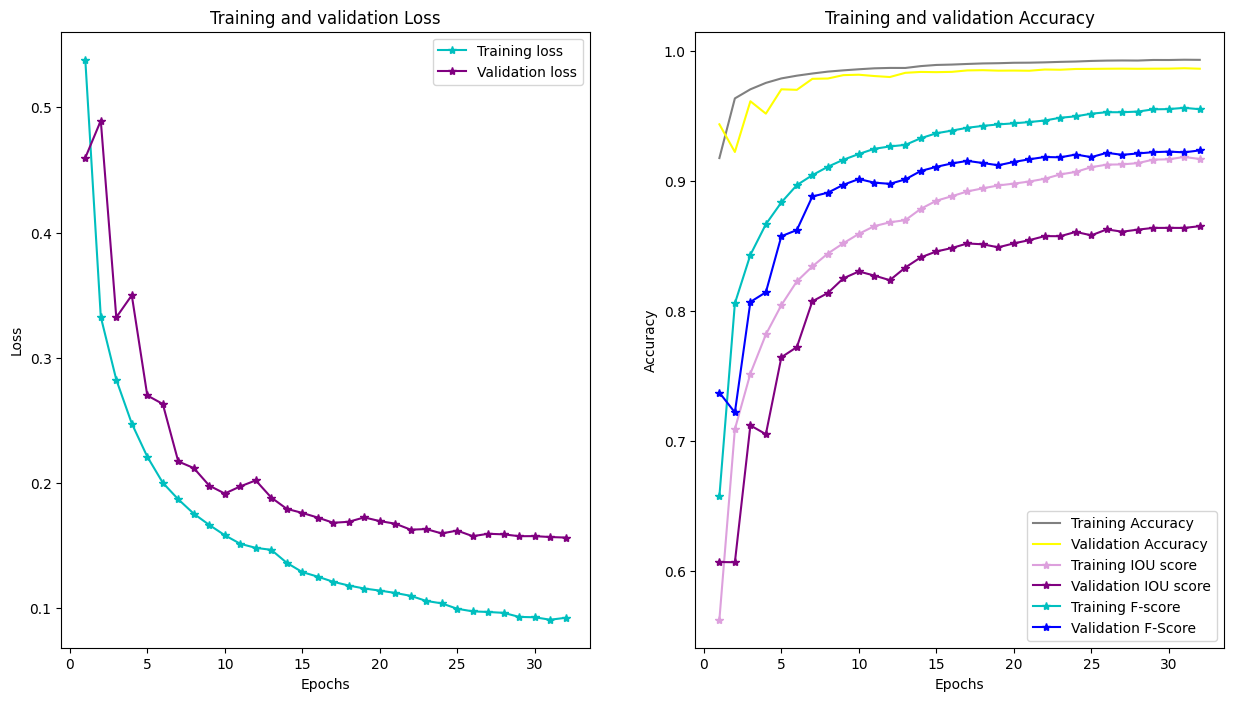

In [13]:
import pandas as pd

log_data = pd.read_csv('FPN_VGG16_segm.log', sep=',', engine='python')
patience = 5

#plot the training and validation accuracy and loss at each epoch
loss = log_data['loss'].iloc[:-patience]
val_loss = log_data['val_loss'].iloc[:-patience]
epochs = range(1, len(loss) + 1)

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 2, 1)
plt.plot(epochs, loss, 'c', marker="*", label='Training loss')
plt.plot(epochs, val_loss, 'purple', marker="*", label='Validation loss')
plt.title('Training and validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


acc = log_data['accuracy'].iloc[:-patience]
val_acc = log_data['val_accuracy'].iloc[:-patience]
iou = log_data['iou_score'].iloc[:-patience]
val_iou = log_data['val_iou_score'].iloc[:-patience]
fscore = log_data['f1-score'].iloc[:-patience]
val_fscore = log_data['val_f1-score'].iloc[:-patience]
ax = fig.add_subplot(1, 2, 2)
plt.plot(epochs, acc, 'gray',   label='Training Accuracy')
plt.plot(epochs, val_acc, 'yellow',  label='Validation Accuracy')
plt.plot(epochs, iou, 'plum',  marker="*", label='Training IOU score')
plt.plot(epochs, val_iou, 'purple', marker="*", label='Validation IOU score')
plt.plot(epochs, fscore, 'c',  marker="*", label='Training F-score')
plt.plot(epochs, val_fscore, 'blue', marker="*", label='Validation F-Score')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
print(f"Accuracy ottenuta {acc.iloc[-1]}, Loss ottenuta: {loss.iloc[-1]}\nVal accuracy: {val_acc.iloc[-1]}, Val loss: {val_loss.iloc[-1]}")
print(f"IOU Score ottenuto {iou.iloc[-1]}, Val IOU Score: {val_iou.iloc[-1]}\nF-Score: {fscore.iloc[-1]}, Val F-score: {val_fscore.iloc[-1]}")

In [14]:
from keras import backend as K
K.clear_session()

#Predizione del modello sul dataset test
y_pred=model.predict(X_test_pro)
#Argmax controlla il valore maggiore dell'asse indicato e prende solo quello
y_pred_argmax=np.argmax(y_pred, axis=3)


1/1 [==============================] - 1s 1s/step


In [15]:
#Controllo effettivamente il modello sul validation set
"""val_res = model.evaluate(X_val_pro,y_val_cat)
print(f"Loss ottenuta sul test: {val_res[0]}\tAccuracy ottenuta sul test: {val_res[3]}")
print(f"IOUscore ottenuto sul test: {val_res[1]}\tF-Score ottenuto sul test: {val_res[2]}")"""

#Controllo i risultati sul test set
results = model.evaluate(X_test_pro)
print(f"Loss ottenuta sul test: {results[0]}\tAccuracy ottenuta sul test: {results[3]}")
print(f"IOUscore ottenuto sul test: {results[1]}\tF-Score ottenuto sul test: {results[2]}")


1/1 [==============================] - 1s 510ms/step - loss: 0.0000e+00 - iou_score: 0.0000e+00 - f1-score: 0.0000e+00 - accuracy: 0.0000e+00
Loss ottenuta sul test: 0.0	Accuracy ottenuta sul test: 0.0
IOUscore ottenuto sul test: 0.0	F-Score ottenuto sul test: 0.0


In [16]:
"""#Per vedere un'unica classe alla volta -> y_pred[n_image][:,:,classe]
classi = ['background', 'car', 'wheel', 'lights', 'windows']
#Using built in keras function
from keras.metrics import MeanIoU
#n_classes = 5
#IOU_keras = MeanIoU(num_classes=n_classes)  
#IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
#print("Mean IoU =", IOU_keras.result().numpy())
#si può calcolare la mean IoU per ogni classe
# target_class_ids indicates the class/classes you want to calculate IoU on
for i in range(5):
    loss = tf.keras.metrics.IoU(num_classes=5, target_class_ids=[i])
    loss.update_state( y_pred_argmax)
    print("Risultato per la classe", classi[i] ,": ",loss.result().numpy())"""

'#Per vedere un\'unica classe alla volta -> y_pred[n_image][:,:,classe]\nclassi = [\'background\', \'car\', \'wheel\', \'lights\', \'windows\']\n#Using built in keras function\nfrom keras.metrics import MeanIoU\n#n_classes = 5\n#IOU_keras = MeanIoU(num_classes=n_classes)  \n#IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)\n#print("Mean IoU =", IOU_keras.result().numpy())\n#si può calcolare la mean IoU per ogni classe\n# target_class_ids indicates the class/classes you want to calculate IoU on\nfor i in range(5):\n    loss = tf.keras.metrics.IoU(num_classes=5, target_class_ids=[i])\n    loss.update_state( y_pred_argmax)\n    print("Risultato per la classe", classi[i] ,": ",loss.result().numpy())'

1/1 [==============================] - 0s 294ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 424ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


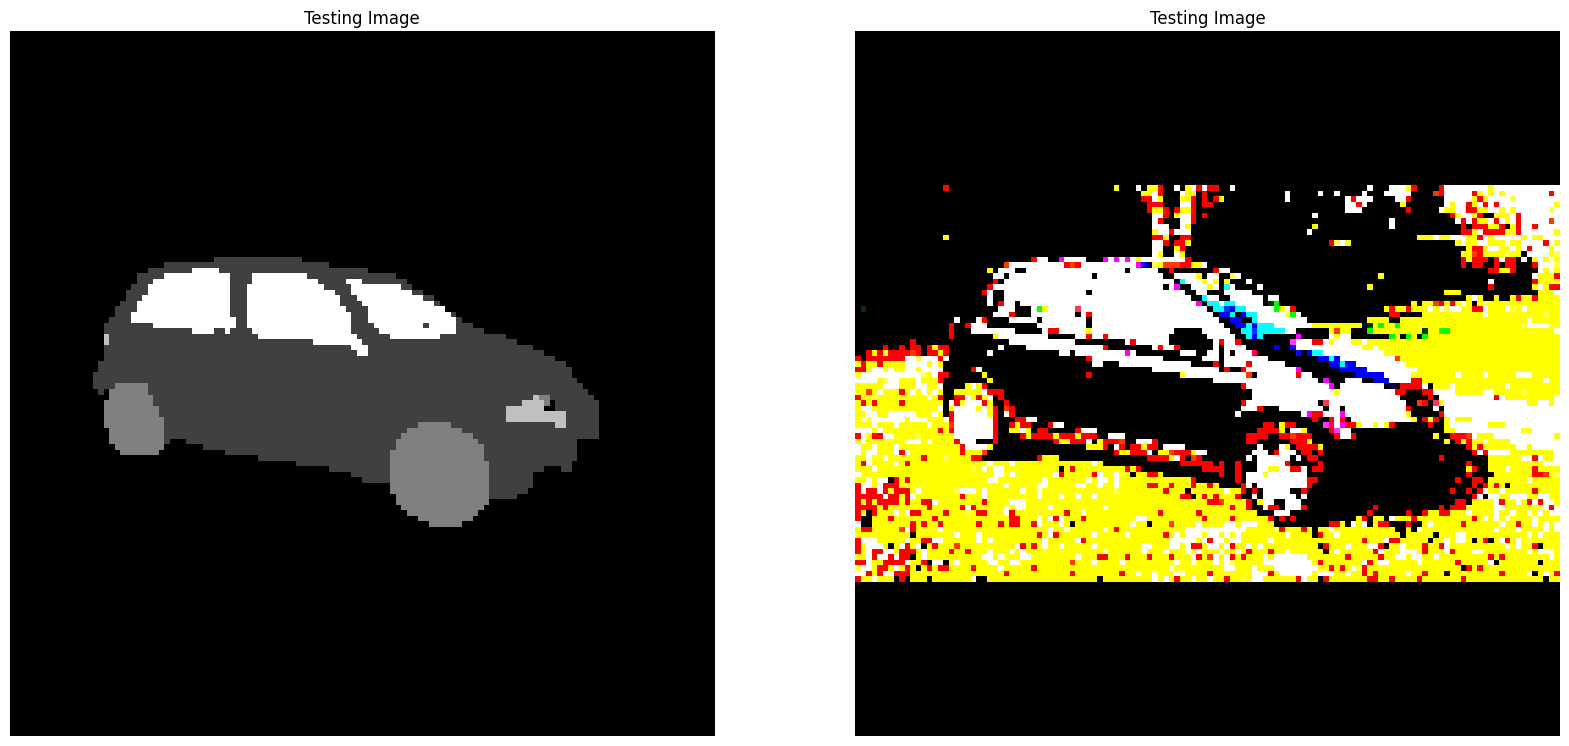

In [22]:
import random

fig = plt.figure(figsize=(20, 20))

for i in range(2):
    number = random.randint(0, len(X_test_pro)-1)
    #Seleziono un'immagine da mostrare""
    img = X_test_pro[number]
    #Seleziono la sua maschera
    #ground_truth=y_test[number]
    

    test_img = X_test_pro[number]
    test_img_input = np.expand_dims(test_img,0)
    prediction = (model.predict(test_img_input))
    
    predicted_img=np.argmax(prediction, axis=3)[0,:,:] #passo da (1,128,128,5) a (128,128)
    
    ax = fig.add_subplot(1, 2, i+1)
    plt.title('Testing Image')
    plt.imshow(img)
    plt.imshow(predicted_img, cmap='gray')
    plt.axis('off')
    
"""    ax = fig.add_subplot(5,4,i*4+1)
    plt.title('Testing Image')
    plt.imshow(img)"""
    

    

plt.imshow(img)
    

   